In [1]:
# Importing the modules
import time
import os
import re

# Image processing...
from PIL import Image

In [2]:
cars = ['Alfa Romeo', 'Audi', 'BMW', 'Chevrolet', 'Citroen', 'Dacia', 'Daewoo', 'Dodge',
        'Ferrari', 'Fiat', 'Ford', 'Honda', 'Hyundai', 'Jaguar', 'Jeep', 'Kia', 'Lada',
        'Lancia', 'Land Rover', 'Lexus', 'Maserati', 'Mazda', 'Mercedes', 'Mitsubishi',
        'Nissan', 'Opel', 'Peugeot', 'Porsche', 'Renault', 'Rover', 'Saab', 'Seat',
        'Skoda', 'Subaru', 'Suzuki', 'Tata', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo']

In [3]:
# Importing standard ML set - numpy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Importing keras and its deep learning tools - neural network model, layers, contraints, optimizers, callbacks and utilities
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras.regularizers import l2
from keras.initializers import RandomNormal, VarianceScaling

# Importing scikit-learn tools
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [4]:
# Setting up the image pool
image_path = "C:\\Users\\New\\Desktop\\images\\"
imgs = os.listdir(image_path)
img_x = img_y = 50   # image size is constant
n_samples = np.size(imgs)
n_samples  # 20778 originally

20778

In [5]:
# Loading all images...
images = np.array([np.array(Image.open(image_path + img).convert("RGB")).flatten() for img in os.listdir(image_path)], order='F', dtype='uint8')
np.shape(images)

(20778, 7500)

In [6]:
# an example image
images[1][1:]

array([255, 255, 249, ..., 255, 255, 255], dtype=uint8)

In [7]:
# Producing labels and assigning them accordingly
labels = np.array([cars.index(re.match(r"(^\D+)", imgs[i])[0]) for i in range(n_samples)])
labels.shape

(20778,)

In [8]:
# Some additional data preparation needs to be done before blasting the images into the neural net
dataset, labelset = shuffle(images, labels, random_state=42)
train_data = [dataset, labelset]

(20778, 7500) (20778,)


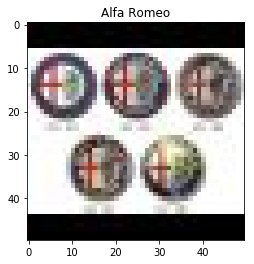

In [9]:
# Testing if the images loaded up okay - 500 should show Alfa Romeo label and a five-logo image
r = 500
print(train_data[0].shape, train_data[1].shape)
plt.imshow(images[r].reshape(img_x, img_y, 3))
plt.title(cars[labels[r]])
plt.show()

# Training and Preparing the Dataset

In [10]:
# We have to prepare the dataset to fit into the CNN
X_train, X_test, y_train, y_test = train_test_split(train_data[0], train_data[1], test_size=0.2)

# we will maintain a copy of the test set, as we will do a couple of transformation to it
X_test_img = X_test.copy()

# let's bring back the images, like above
X_train = X_train.reshape(X_train.shape[0], img_x, img_y, 3)
X_test = X_test.reshape(X_test.shape[0], img_x, img_y, 3)

# Now for some convergence-friendly procedure (is supposed to converge a lot faster when brought to 0-1 float)...
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# ...and some additional pre-processing, to zero-center the data...
X_train = np.subtract(X_train, 0.5)
X_test = np.subtract(X_test, 0.5)

# ...and to scale it to (-1, 1)
X_train = np.multiply(X_train, 2.0)
X_test = np.multiply(X_test, 2.0)

# Labels have to be transformed to categorical
Y_train = np_utils.to_categorical(y_train, num_classes=len(cars))
Y_test = np_utils.to_categorical(y_test, num_classes=len(cars))

In [11]:
# All should be okay, but we still need some heavy data augmentation, as 20k samples with 40 labels is a bit too few...
X_train.shape, X_test.shape

((16622, 50, 50, 3), (4156, 50, 50, 3))

# Data Augmentation

In [12]:
# In order to process data augmentation, keras' ImageDataGenerator can apply some transformations to images on random
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    # featurewise_center=False,
    # samplewise_center=False,
    # featurewise_std_normalization=True,
    # samplewise_std_normalization=True,
    # zca_whitening=True,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

# Applying ImageDataGenerator - training with the augmented dataset
A note has to be made here: I tried to use the regular .fit() method, but probably due to unbalanced and relatively small dataset, it reached the accuracy of some 72%-73% at best, with the loss on the validation set at some 1.2 at best. Using the virtually augmented dataset boosted the accuracy score beyond 80% and lowered the val_loss parameter below 1.0. I assumed and saved the best trained model

In [13]:
# It has to be 'fit' into the training set, which will take a while...
datagen.fit(X_train)

# Building the CNN model

In [14]:
# Finally for some CNN construction!

# setting up batch size
batch = 128

# there are 40 brands altogether, so far, but let's make it official
n_classes = len(cars)

# setting up the number of epochs to be trained
n_epochs = 200

# images are RGB, so they use up 3 channels for Red, Green and Blue, respectively
n_channels = 3

In [15]:
# Convolutional Neural Network will be composed of four Conv/MaxPool blocks, a flattening layer and two dense layers at the end
# (before the final classification layer, that is)

# The model will have a sequential architecture
# NOTE: kernel and bias had to be fine-tuned in order to increase the chance of converging

model = Sequential()
model.add(Conv2D(32, (3,3),
                 input_shape=(img_x,img_y,n_channels),
                 padding='valid',
                 bias_initializer='glorot_uniform',
                 kernel_regularizer=l2(0.00004),
                 kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3),
                 padding='valid',
                 bias_initializer='glorot_uniform',
                 kernel_regularizer=l2(0.00004),
                 kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3),
                 padding='valid',
                 bias_initializer='glorot_uniform',
                 kernel_regularizer=l2(0.00004),
                 kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3,3),
                 padding='valid',
                 bias_initializer='glorot_uniform',
                 kernel_regularizer=l2(0.00004),
                 kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(4096, activation='relu', bias_initializer='glorot_uniform'))
model.add(Dropout(0.5))

model.add(Dense(4096, activation='relu', bias_initializer='glorot_uniform'))
model.add(Dropout(0.5))

# final activation is softmax, tuned to the number of classes/labels possible
model.add(Dense(len(cars), activation='softmax'))

# Some callbacks have to be provided to choose the best trained model
# patience set at 4 as 3 was too greedy - I observed better results after the third-worse epoch
early_stopping = EarlyStopping(patience=4, monitor='val_loss')
CNN_file = 'car_CNN_13AUGM_CMCMCMCMF.h5py' # the 13th try, with augmented data
take_best_model = ModelCheckpoint(CNN_file, save_best_only=True)

# optimizer will be a stochastic gradient descent, learning rate set at 0.005
sgd = SGD(lr=0.005, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['categorical_accuracy'])

# Let's look at the summary
model.summary()

W0907 23:52:11.223592 12628 deprecation_wrapper.py:119] From C:\Users\New\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0907 23:52:12.456630 12628 deprecation_wrapper.py:119] From C:\Users\New\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0907 23:52:12.966943 12628 deprecation_wrapper.py:119] From C:\Users\New\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0907 23:52:13.328450 12628 deprecation_wrapper.py:119] From C:\Users\New\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0907 23:52:13.469120 12628 deprecation_wrapper.py:119] From C:\Users\Ne

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 256)        

In [16]:
# Training time was around 4 minutes per epoch, restarting a few times - it takes lot of hours depend upon the batch size and no. of epochs
""""model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch, shuffle=True, seed=42),\
                    steps_per_epoch=X_train.shape[0]//batch, epochs=n_epochs,\
                    validation_data=(X_test, Y_test), workers=4)"""

'"model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch, shuffle=True, seed=42),                    steps_per_epoch=X_train.shape[0]//batch, epochs=n_epochs,                    validation_data=(X_test, Y_test), workers=4)'

In [17]:
model.load_weights('car_CNN_13AUGM_CMCMCMCMF.h5py')

In [18]:
X_train.shape

(16622, 50, 50, 3)

In [19]:
# I will need that later to re-convert my flattened images to their previous state
def ImageConvert(n, i):
    im_ex = i.reshape(n, img_x, img_y, 3)
    im_ex = im_ex.astype('float32') / 255
    im_ex = np.subtract(im_ex, 0.5)
    im_ex = np.multiply(im_ex, 2.0)
    return im_ex

# Metrics of Success

In [20]:
scores = model.evaluate(X_test, Y_test) # let's look at the accuracy on the test set
print("Accuracy test: %.2f%%" % (scores[1]*100))

4156/4156 [==============================] - 14s 3ms/step
Accuracy test: 94.59%


In [21]:
from sklearn.metrics import precision_recall_fscore_support as prfs

# Preparing for metrics check-up on the test set, may take a while...
Y_pred = model.predict_classes(X_test)

In [22]:
precision, recall, f1, support = prfs(y_test, Y_pred, average='weighted')
print("Precision: {:.2%}\nRecall: {:.2%}\nF1 score: {:.2%}\nAccuracy: {:.2%}".format(precision, recall, f1, scores[1]))

Precision: 94.67%
Recall: 94.59%
F1 score: 94.59%
Accuracy: 94.59%


In [23]:
# But let's check per class, too - assuming that larger datasets will be having higher metrics
precision_, recall_, f1_, support_ = prfs(y_test, Y_pred, average=None)

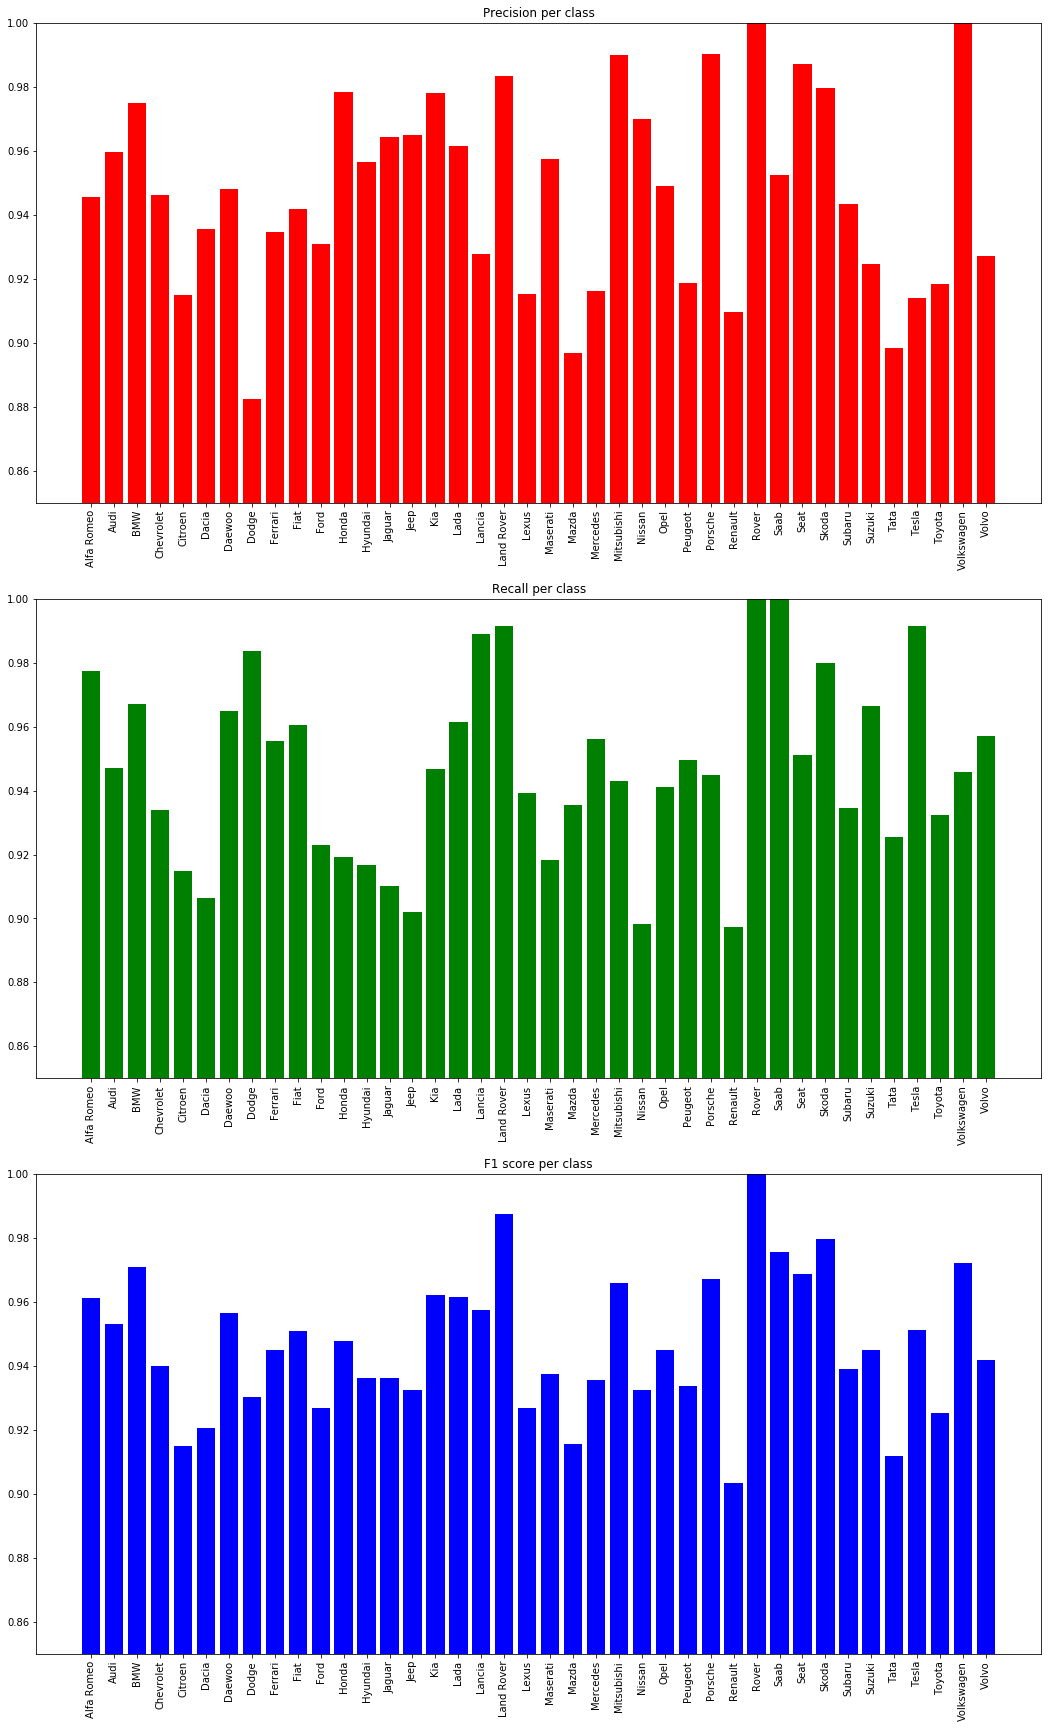

In [24]:
# We see that smaller sets have generally worse precision and recall
plt.subplots(figsize=(18,30))
x = range(len(cars))
plt.subplot(311)
plt.title('Precision per class')
plt.ylim(0.85, 1.00)
plt.bar(x, precision_, color='Red')
plt.xticks(x, cars, rotation = 90)
plt.subplot(312)
plt.title('Recall per class')
plt.ylim(0.85, 1.00)
plt.bar(x, recall_, color='Green')
plt.xticks(x, cars, rotation = 90)
plt.subplot(313)
plt.title('F1 score per class')
plt.ylim(0.85, 1.00)
plt.bar(x, f1_, color='Blue')
plt.xticks(x, cars, rotation = 90)
plt.show()

# Showcasing

In [27]:
# OK, let's try the CNN in action - first defining the ShowCase() method to show everything nicely

def ShowCase(cols, rows):
    fdict = {'fontsize': 24,
            'fontweight' : 'normal',
            'verticalalignment': 'baseline'}
    plt.figure(figsize=(cols * 5, rows * 4))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    c = 0
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        
        # r - randomly picked from the whole dataset
        r = np.random.randint(np.shape(images)[0])
        
        # j - predicted class for the image of index r (weird syntax, but works :)
        j = int(model.predict_classes(ImageConvert(1, images[r:r+1]), verbose=0))
        
        # increase success if predicted well
        if labels[r] == j:
            c += 1
        
        # image needs reshaping back to a 50px*50px*RGB
        plt.imshow(images[r].reshape(img_x, img_y, 3))
        
        # plt.title will show the true brand and the predicted brand
        plt.title('True brand: '+cars[labels[r]]+'\nPredicted: '+cars[j],
                  color= 'Green' if cars[labels[r]] == cars[j] else 'Red', fontdict=fdict) # Green for right, Red for wrong
        
        # no ticks
        plt.xticks(())
        plt.yticks(())
        
    # print out the success rate
    print('Success rate: {}/{} ({:.2%})'.format(c, rows*cols, c/(rows*cols)))
    
    plt.show()

Success rate: 48/50 (96.00%)


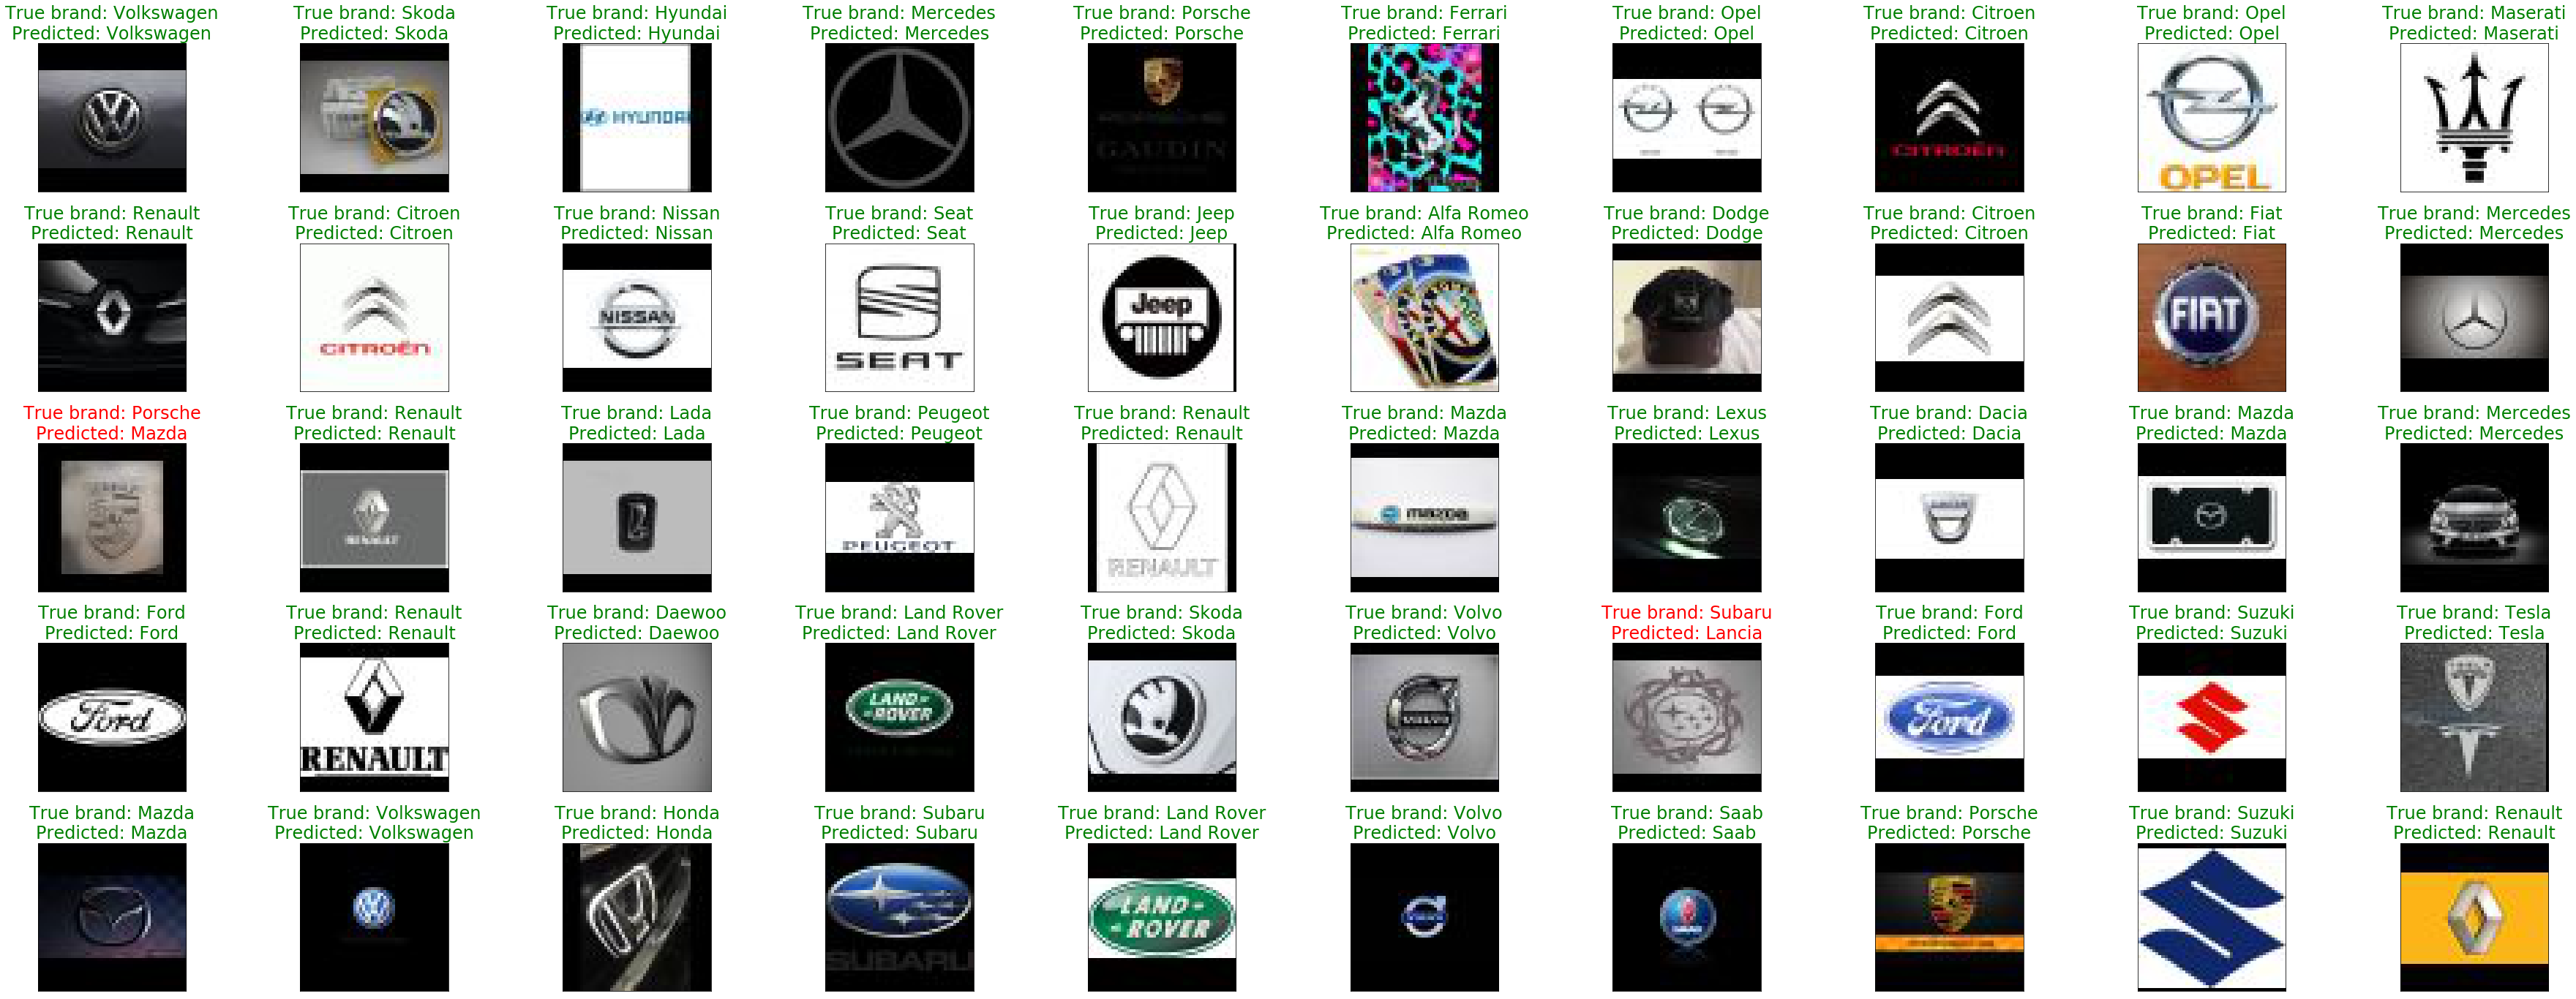

In [28]:
# That is strictly for the showcasing, how the CNN works - ain't that bad, after all :)
ShowCase(10, 5)

# New input - testing beyond the test set

Let's try to test CNN. There were some new images of car logo which is never seen by a model, let's see if it can predict the right logo or not.

In [29]:
# Setting up the image pool
new_image_path = "C:\\Users\\New\\Desktop\\new_images\\"
new_imgs = os.listdir(new_image_path)
new_n_samples = np.size(new_imgs)
new_n_samples # 8

8

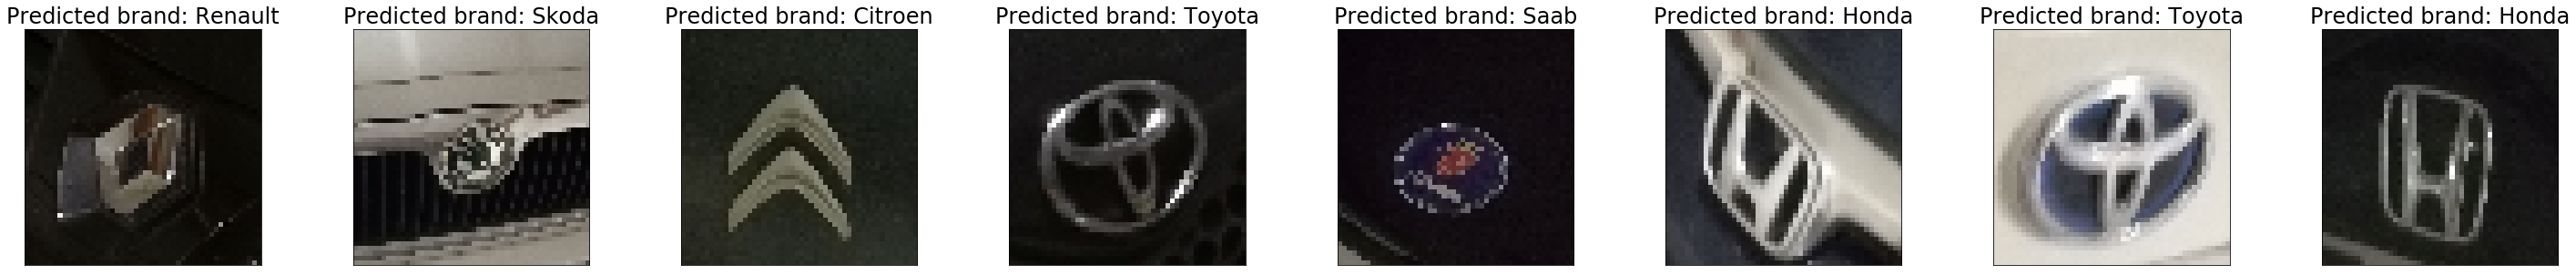

In [30]:
# Let's do some showcasing on-the-fly....
cols = 8
rows = 1
plt.figure(figsize=(cols * 5, rows * 4))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
for i in range(new_n_samples):
    plt.subplot(rows, cols, i + 1)
    im = Image.open(new_image_path+new_imgs[i]).convert("RGB")
    new_im = np.array(im.resize((50,50))).flatten()
    m = int(model.predict_classes(ImageConvert(1, new_im), verbose=0))
    plt.imshow(new_im.reshape(img_x, img_y, 3))
    plt.title('Predicted brand: '+cars[m], size=24)
    plt.xticks(())
    plt.yticks(())
plt.show()

# 100% success! :)